In [232]:
from IPython.display import display, HTML
import pyspark
from pyspark.sql import SparkSession, SQLContext, Row, DataFrame
display(HTML('<style>pre { white-space: pre !important; }</style>'))
from pyspark.sql import Window
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format, dayofweek, from_unixtime, to_timestamp, to_date, unix_timestamp, col, udf, lit, stddev, format_number, mean, split, explode, when, avg, percentile_approx, element_at, arrays_zip, corr
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, StringIndexer, PCA
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, abs
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [122]:
spark : SparkSession = SparkSession.builder.appName("the_mighty_(sad_little)_low_mist").getOrCreate()

In [192]:
STOCKS = "../data/stocks.csv"
SPOTIFY = "../data/spotify.parquet"

In [5]:
df : DataFrame = spark.read.csv(STOCKS, header=True, inferSchema=True)

In [6]:
df

DataFrame[Date: date, Open: double, High: double, Low: double, Close: double, Volume: int, Adj Close: double]

In [7]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



In [8]:
df.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|212.79999700000002|        213.000002|      

In [9]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|summary|              Open|              High|               Low|            Close|             Volume|         Adj Close|
+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|  count|              1762|              1762|              1762|             1762|               1762|              1762|
|   mean| 313.0763111589103| 315.9112880164581| 309.8282405079457|312.9270656379113|9.422577587968218E7| 75.00174115607275|
| stddev|185.29946803981522|186.89817686485767|183.38391664371008|185.1471036170943|6.020518776592709E7| 28.57492972179906|
|    min|              90.0|         90.699997|         89.470001|        90.279999|           11475900|         24.881912|
|    max|        702.409988|        705.070023|        699.569977|       702.100021|          470249500|127.96609099999999|
+-------

btw sth interesting:
DataFrame.collect() collects the distributed data to the driver side as the local data in Python. Note that this can throw an out-of-memory error when the dataset is too large to fit in the driver side because it collects all the data from executors to the driver side.

In [10]:
selected_df = df.filter(df["Close"] < 500).select("Open", "Close", "Volume")
selected_df.show()

+------------------+------------------+---------+
|              Open|             Close|   Volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
|        208.330002|        215.039995|182501900|
|        214.910006|            211.73|153038200|
|        212.079994|        208.069996|152038600|
|206.78000600000001|            197.75|220441900|
|202.51000200000001|        203.070002|266424900|
|205.95000100000001|        205.940001|466777500|
|        206.849995|        207.880005|430642100|


In [11]:
df.createOrReplaceTempView("stocks") # this shit is needed for running sql, and in sql you should specify FROM your_ass

In [12]:
selected_df = spark.sql("SELECT Open, Close, Volume FROM stocks WHERE Close < 500")
selected_df.show() # i saw you standing in the rain, you were holding her handssssssssssssssssssss

+------------------+------------------+---------+
|              Open|             Close|   Volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
|        208.330002|        215.039995|182501900|
|        214.910006|            211.73|153038200|
|        212.079994|        208.069996|152038600|
|206.78000600000001|            197.75|220441900|
|202.51000200000001|        203.070002|266424900|
|205.95000100000001|        205.940001|466777500|
|        206.849995|        207.880005|430642100|


In [13]:
selected_df = df[(df["Open"] > 200) & (df["Close"] < 200)]
selected_df.show()

+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+



In [14]:
selected_df = spark.sql("SELECT * FROM stocks WHERE Open > 200 AND Close < 200")
selected_df.show() # boooooooooooooooooooooooooooooooooooooooobs

+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+



In [15]:
df_year = df.withColumn("Year", year(df["Date"]))
df_year.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
|2010-01-11|212.

In [16]:
df_year = spark.sql("SELECT *, YEAR(Date) as Year FROM stocks")
df_year.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
|2010-01-11|212.

In [17]:
df_min_volume = df_year.groupBy("Year").agg(F.min("Volume").alias("minVolume"))
df_min_volume.show()

+----+---------+
|Year|minVolume|
+----+---------+
|2015| 13046400|
|2013| 41888700|
|2014| 14479600|
|2012| 43938300|
|2016| 11475900|
|2010| 39373600|
|2011| 44915500|
+----+---------+



In [18]:
df_year.createOrReplaceTempView("stocks_year")

In [19]:
df_min_volume = spark.sql("SELECT Year, MIN(Volume) as minVolume FROM stocks_year GROUP BY Year")
df_min_volume.show()

+----+---------+
|Year|minVolume|
+----+---------+
|2015| 13046400|
|2013| 41888700|
|2014| 14479600|
|2012| 43938300|
|2016| 11475900|
|2010| 39373600|
|2011| 44915500|
+----+---------+



In [21]:
df_with_year_and_month = df_year.withColumn("Month", F.month(df["Date"]))
df_with_year_and_month.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|Month|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|    1|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|    1|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|    1|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|    1|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700

In [22]:
df_with_year_and_month = spark.sql("SELECT *, MONTH(Date) as Month FROM stocks_year")
df_with_year_and_month.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|Month|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|    1|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|    1|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|    1|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|    1|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700

In [24]:
df_max_low = df_with_year_and_month.groupBy("Year", "Month").agg(F.max("Low").alias("maxLow")).sort("Year", "Month")
df_max_low.show() # show(kir) for more rows

+----+-----+------------------+
|Year|Month|            maxLow|
+----+-----+------------------+
|2010|    1|        213.249994|
|2010|    2|        202.000004|
|2010|    3|        234.459999|
|2010|    4|268.19001000000003|
|2010|    5|        262.880009|
|2010|    6|        271.499992|
|2010|    7|        260.300003|
|2010|    8|        260.549995|
|2010|    9|        291.009998|
|2010|   10|        314.289997|
|2010|   11|        316.759987|
|2010|   12|        325.099991|
|2011|    1|        344.440006|
|2011|    2|             360.5|
|2011|    3|        357.750004|
|2011|    4|        350.300007|
|2011|    5|        346.880009|
|2011|    6|        344.649998|
|2011|    7|399.67998900000003|
|2011|    8|        392.369995|
+----+-----+------------------+
only showing top 20 rows



In [26]:
df_with_year_and_month.createOrReplaceTempView("stocks_year_month")

In [27]:
df_max_low = spark.sql("SELECT Year, Month, MAX(Low) as maxLow FROM stocks_year_month GROUP BY Year, Month ORDER BY Year, Month")
df_max_low.show()

+----+-----+------------------+
|Year|Month|            maxLow|
+----+-----+------------------+
|2010|    1|        213.249994|
|2010|    2|        202.000004|
|2010|    3|        234.459999|
|2010|    4|268.19001000000003|
|2010|    5|        262.880009|
|2010|    6|        271.499992|
|2010|    7|        260.300003|
|2010|    8|        260.549995|
|2010|    9|        291.009998|
|2010|   10|        314.289997|
|2010|   11|        316.759987|
|2010|   12|        325.099991|
|2011|    1|        344.440006|
|2011|    2|             360.5|
|2011|    3|        357.750004|
|2011|    4|        350.300007|
|2011|    5|        346.880009|
|2011|    6|        344.649998|
|2011|    7|399.67998900000003|
|2011|    8|        392.369995|
+----+-----+------------------+
only showing top 20 rows



In [29]:
df_stats = df.select(format_number(mean("High"), 2).alias("Mean_High"), 
                     format_number(stddev("High"), 2).alias("StdDev_High"))
df_stats.show()

+---------+-----------+
|Mean_High|StdDev_High|
+---------+-----------+
|   315.91|     186.90|
+---------+-----------+



In [31]:
result = spark.sql("SELECT FORMAT_NUMBER(AVG(High), 2) as Mean_High, FORMAT_NUMBER(STDDEV(High), 2) as StdDev_High FROM stocks")
result.show()

+---------+-----------+
|Mean_High|StdDev_High|
+---------+-----------+
|   315.91|     186.90|
+---------+-----------+



---

In [196]:
spark = SparkSession.builder.appName("PCA").config("spark.executor.memory", "2g").getOrCreate()

In [197]:
df : DataFrame = spark.read.parquet(SPOTIFY)
df.show(truncate=False)

+----------------------+----------------------+-------------------------+----------------------+----------------------------+--------------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+
|id                    |name                  |album                    |album_id              |artists                     |artist_ids                |track_number|disc_number|explicit|danceability      |energy            |key|loudness           |mode|speechiness|acousticness     |instrumentalness    |liveness          |valence           |tempo             |duration_ms|time_signature|year|release_date|
+----------------------+----------------------+-------------------------+----------------------+----------------------------+--------------------------+------------+-----------+--------+

In [198]:
df

DataFrame[id: string, name: string, album: string, album_id: string, artists: string, artist_ids: string, track_number: bigint, disc_number: bigint, explicit: boolean, danceability: double, energy: double, key: bigint, loudness: double, mode: bigint, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, duration_ms: bigint, time_signature: double, year: bigint, release_date: string]

In [199]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



- **id**: A unique identifier for each track.
- **name**: The name of the track.
- **album**: The album to which the track belongs.
- **album_id**: A unique identifier for the album.
- **artists**: The artist or artists who performed the track.
- **artist_ids**: Unique identifiers for the artist or artists.
- **track_number**: The track's position on the album.
- **disc_number**: The number of the disc on which the track appears (useful for multi-disc albums).
- **explicit**: A boolean value indicating whether the track has explicit lyrics.
- **danceability**: A measure of how suitable the track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity.
- **energy**: A measure of intensity and activity, typically higher for faster, louder, more energetic tracks.
- **key**: The key of the track (e.g., C, C#, D, etc. which is represented numerically from 0 to 11).
- **loudness**: The overall loudness of the track in decibels.
- **mode**: The modality of the track (major or minor).
- **speechiness**: A measure of the presence of spoken words in the track.
- **acousticness**: A measure of whether the track is acoustic.
- **instrumentalness**: A measure of the likelihood the track is instrumental.
- **liveness**: A measure of the presence of an audience in the recording of the track.
- **valence**: A measure of musical positiveness conveyed by a track.
- **tempo**: The overall estimated tempo of the track in beats per minute.
- **duration_ms**: The duration of the track in milliseconds.
- **time_signature**: An estimated overall time signature of a track.
- **year**: The year the track was released.
- **release_date**: The exact date when the track was released.


In [200]:
df = df.withColumn("release_date", to_date(df["release_date"]))
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: date (nullable = true)



In [201]:
for col in df.columns:
    print(f"{col}: {df.filter(df[col].isNull()).count()}")

id: 0
name: 3
album: 11
album_id: 0
artists: 0
artist_ids: 0
track_number: 0
disc_number: 0
explicit: 0
danceability: 0
energy: 0
key: 0
loudness: 0
mode: 0
speechiness: 0
acousticness: 0
instrumentalness: 0
liveness: 0
valence: 0
tempo: 0
duration_ms: 0
time_signature: 0
year: 0
release_date: 0


In [202]:
df = df.na.drop()

for col in df.columns:
    print(f"{col}: {df.filter(df[col].isNull()).count()}")

id: 0
name: 0
album: 0
album_id: 0
artists: 0
artist_ids: 0
track_number: 0
disc_number: 0
explicit: 0
danceability: 0
energy: 0
key: 0
loudness: 0
mode: 0
speechiness: 0
acousticness: 0
instrumentalness: 0
liveness: 0
valence: 0
tempo: 0
duration_ms: 0
time_signature: 0
year: 0
release_date: 0


In [203]:
duplicates_df = df.groupBy(df.columns).count().where(F.col("count") > 1)
duplicates_df.show()

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|count|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+



In [204]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+--------

In [205]:
print(f"before split: {df.count()}")

df = df.withColumn("artists", split(df["artists"], ","))
df = df.withColumn("artist_ids", split(df["artist_ids"], ","))

df = df.withColumn("artist_and_id", arrays_zip("artists", "artist_ids"))
df = df.withColumn("artist_and_id", explode("artist_and_id"))

df = df.withColumn("artist", df["artist_and_id"].artists)
df = df.withColumn("artist_id", df["artist_and_id"].artist_ids)

df = df.drop("artist_and_id")

print(f"after split: {df.count()}")

df.show()

before split: 1204012
after split: 1808544
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|
+--------------------+--------------------+--------------------+--------------------+--------------------+---

In [206]:
df = df.withColumn("mode", when(F.col("mode") == 1, True).otherwise(False))
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+----------

In [207]:
df = df.withColumn("duration_min", F.round(F.col("duration_ms") / 60000, 2))
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------------

In [208]:
assembler = VectorAssembler(inputCols=["loudness"], outputCol="loudness_vec")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="loudness_vec", outputCol="loudness_scaled", withStd=True, withMean=True)

scalerModel = scaler.fit(df)

df = scalerModel.transform(df)

df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        loudness_vec|     loudness_scaled|
+--------------------+------------------

In [209]:
df = df.withColumn("loudness_energy_diff", df["loudness"] - df["energy"])
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        loudness_vec|     loudness_scaled|loudness_energy_diff

In [210]:
df = df.withColumn("dance_valence_interaction", df["danceability"] * df["valence"])
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        loudness_vec|     loudness_s

In [211]:
df = df.withColumn("song_age", lit(2024) - year("release_date"))
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------------+--------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        loudness_vec|     l

In [212]:
window = Window.partitionBy("year")
df = df.withColumn("avg_yearly_loudness", avg(df["loudness"]).over(window))
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+------------------+------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------------+--------+-------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|      acousticness|  instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        l

In [213]:
column_types = dict(df.dtypes)

numerics = [col for col, dtype in column_types.items() if dtype in ["int", "double", "long"]]

for col in numerics:
    quantiles = df.approxQuantile(col, [0.25, 0.75], 0.25)
    if quantiles:
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df.filter((df[col] > lower_bound) & (df[col] < upper_bound))
    
df.show()  # FIXME: based on plots later this cell is not working right

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+-----+-----------+------------------+------------------+------------------+------------------+------------------+-----------+--------------+----+------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------------+--------+-------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness| mode|speechiness|      acousticness|  instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|              artist|           artist_id|duration_min|        l

<Axes: >

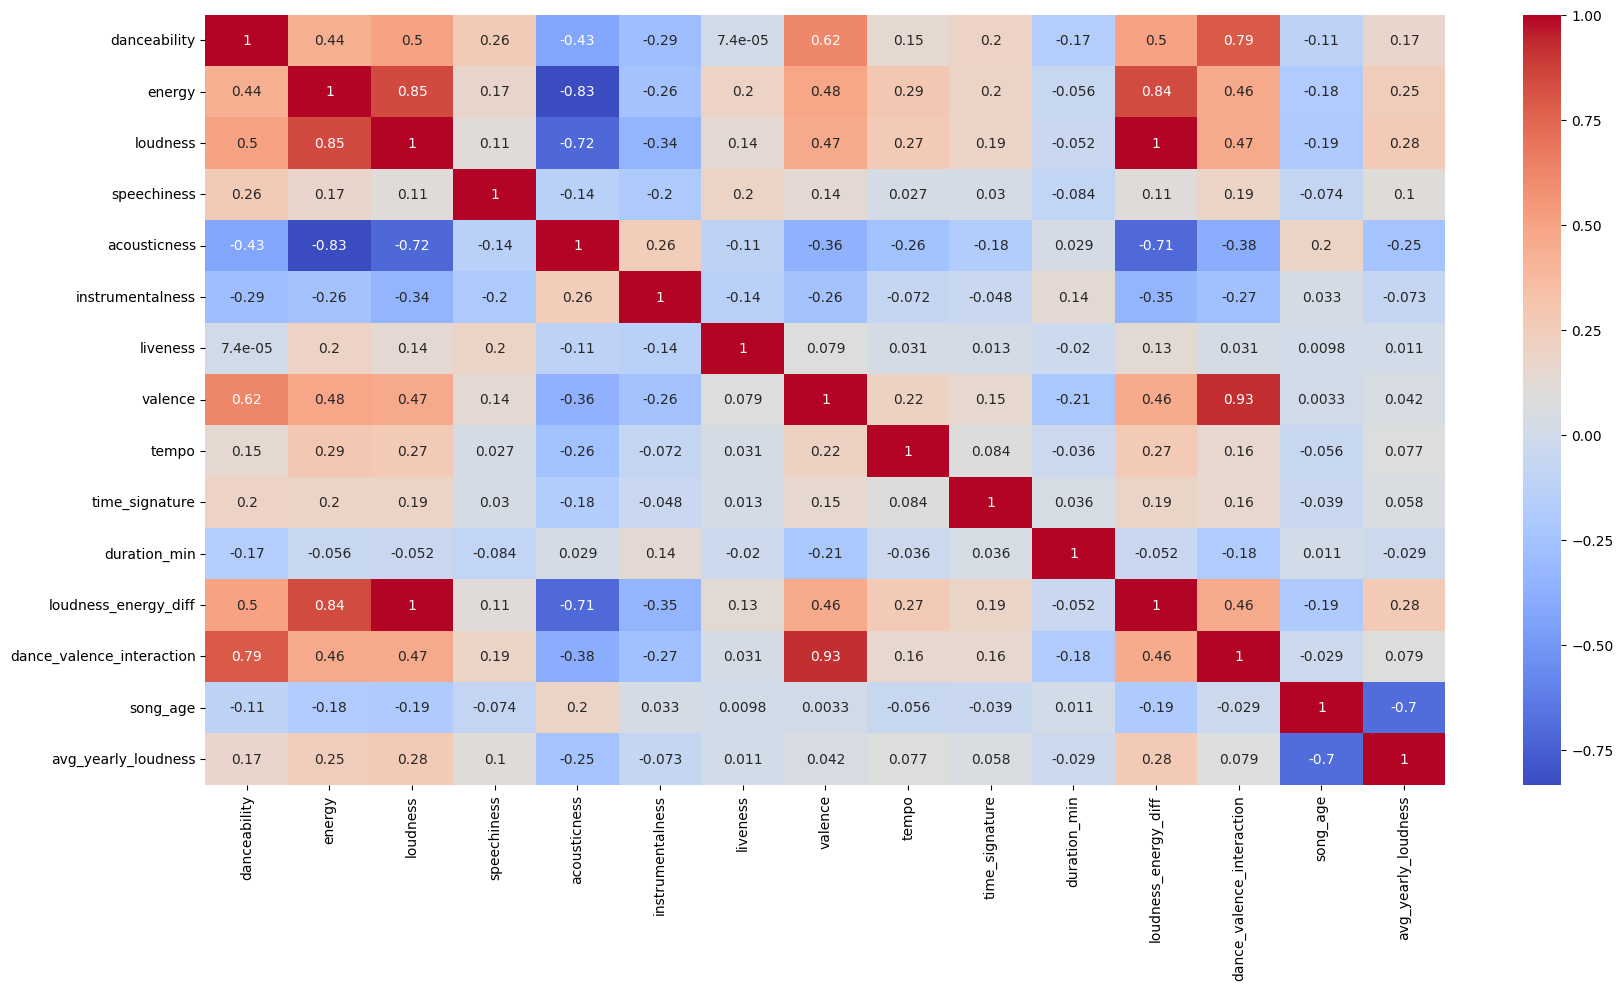

In [214]:
numeric_features = [t[0] for t in df.dtypes if t[1] == "int" or t[1] == "double"]
numeric_data = df.select(numeric_features)
correlation_matrix = numeric_data.toPandas().corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

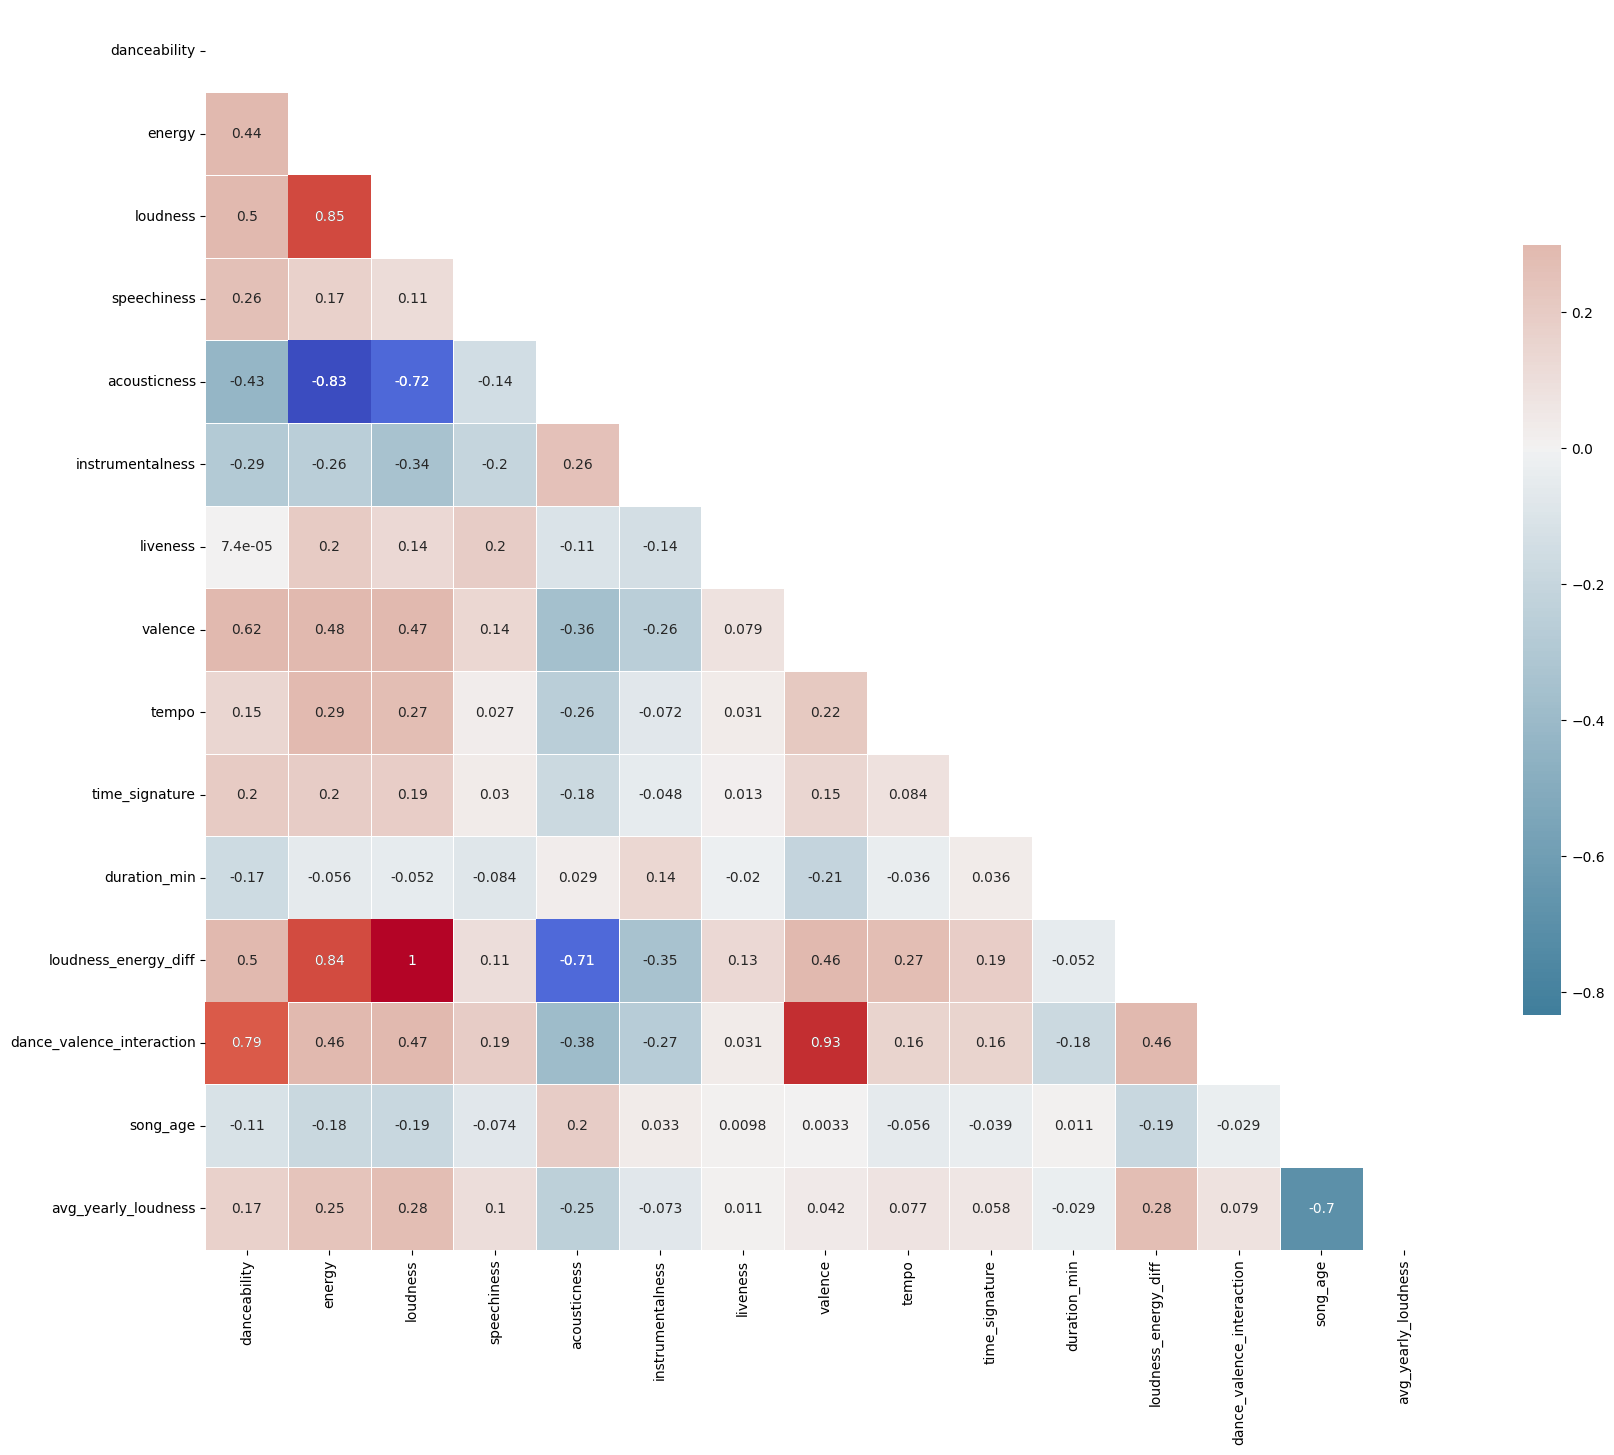

In [215]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

threshold = 0.7
significant = (np.abs(correlation_matrix) >= threshold) & (np.abs(correlation_matrix) < 1)
sns.heatmap(
    correlation_matrix,
    mask=~significant | mask,
    cmap="coolwarm",
    cbar=False,
    annot=True,
    ax=ax,
)

plt.show()

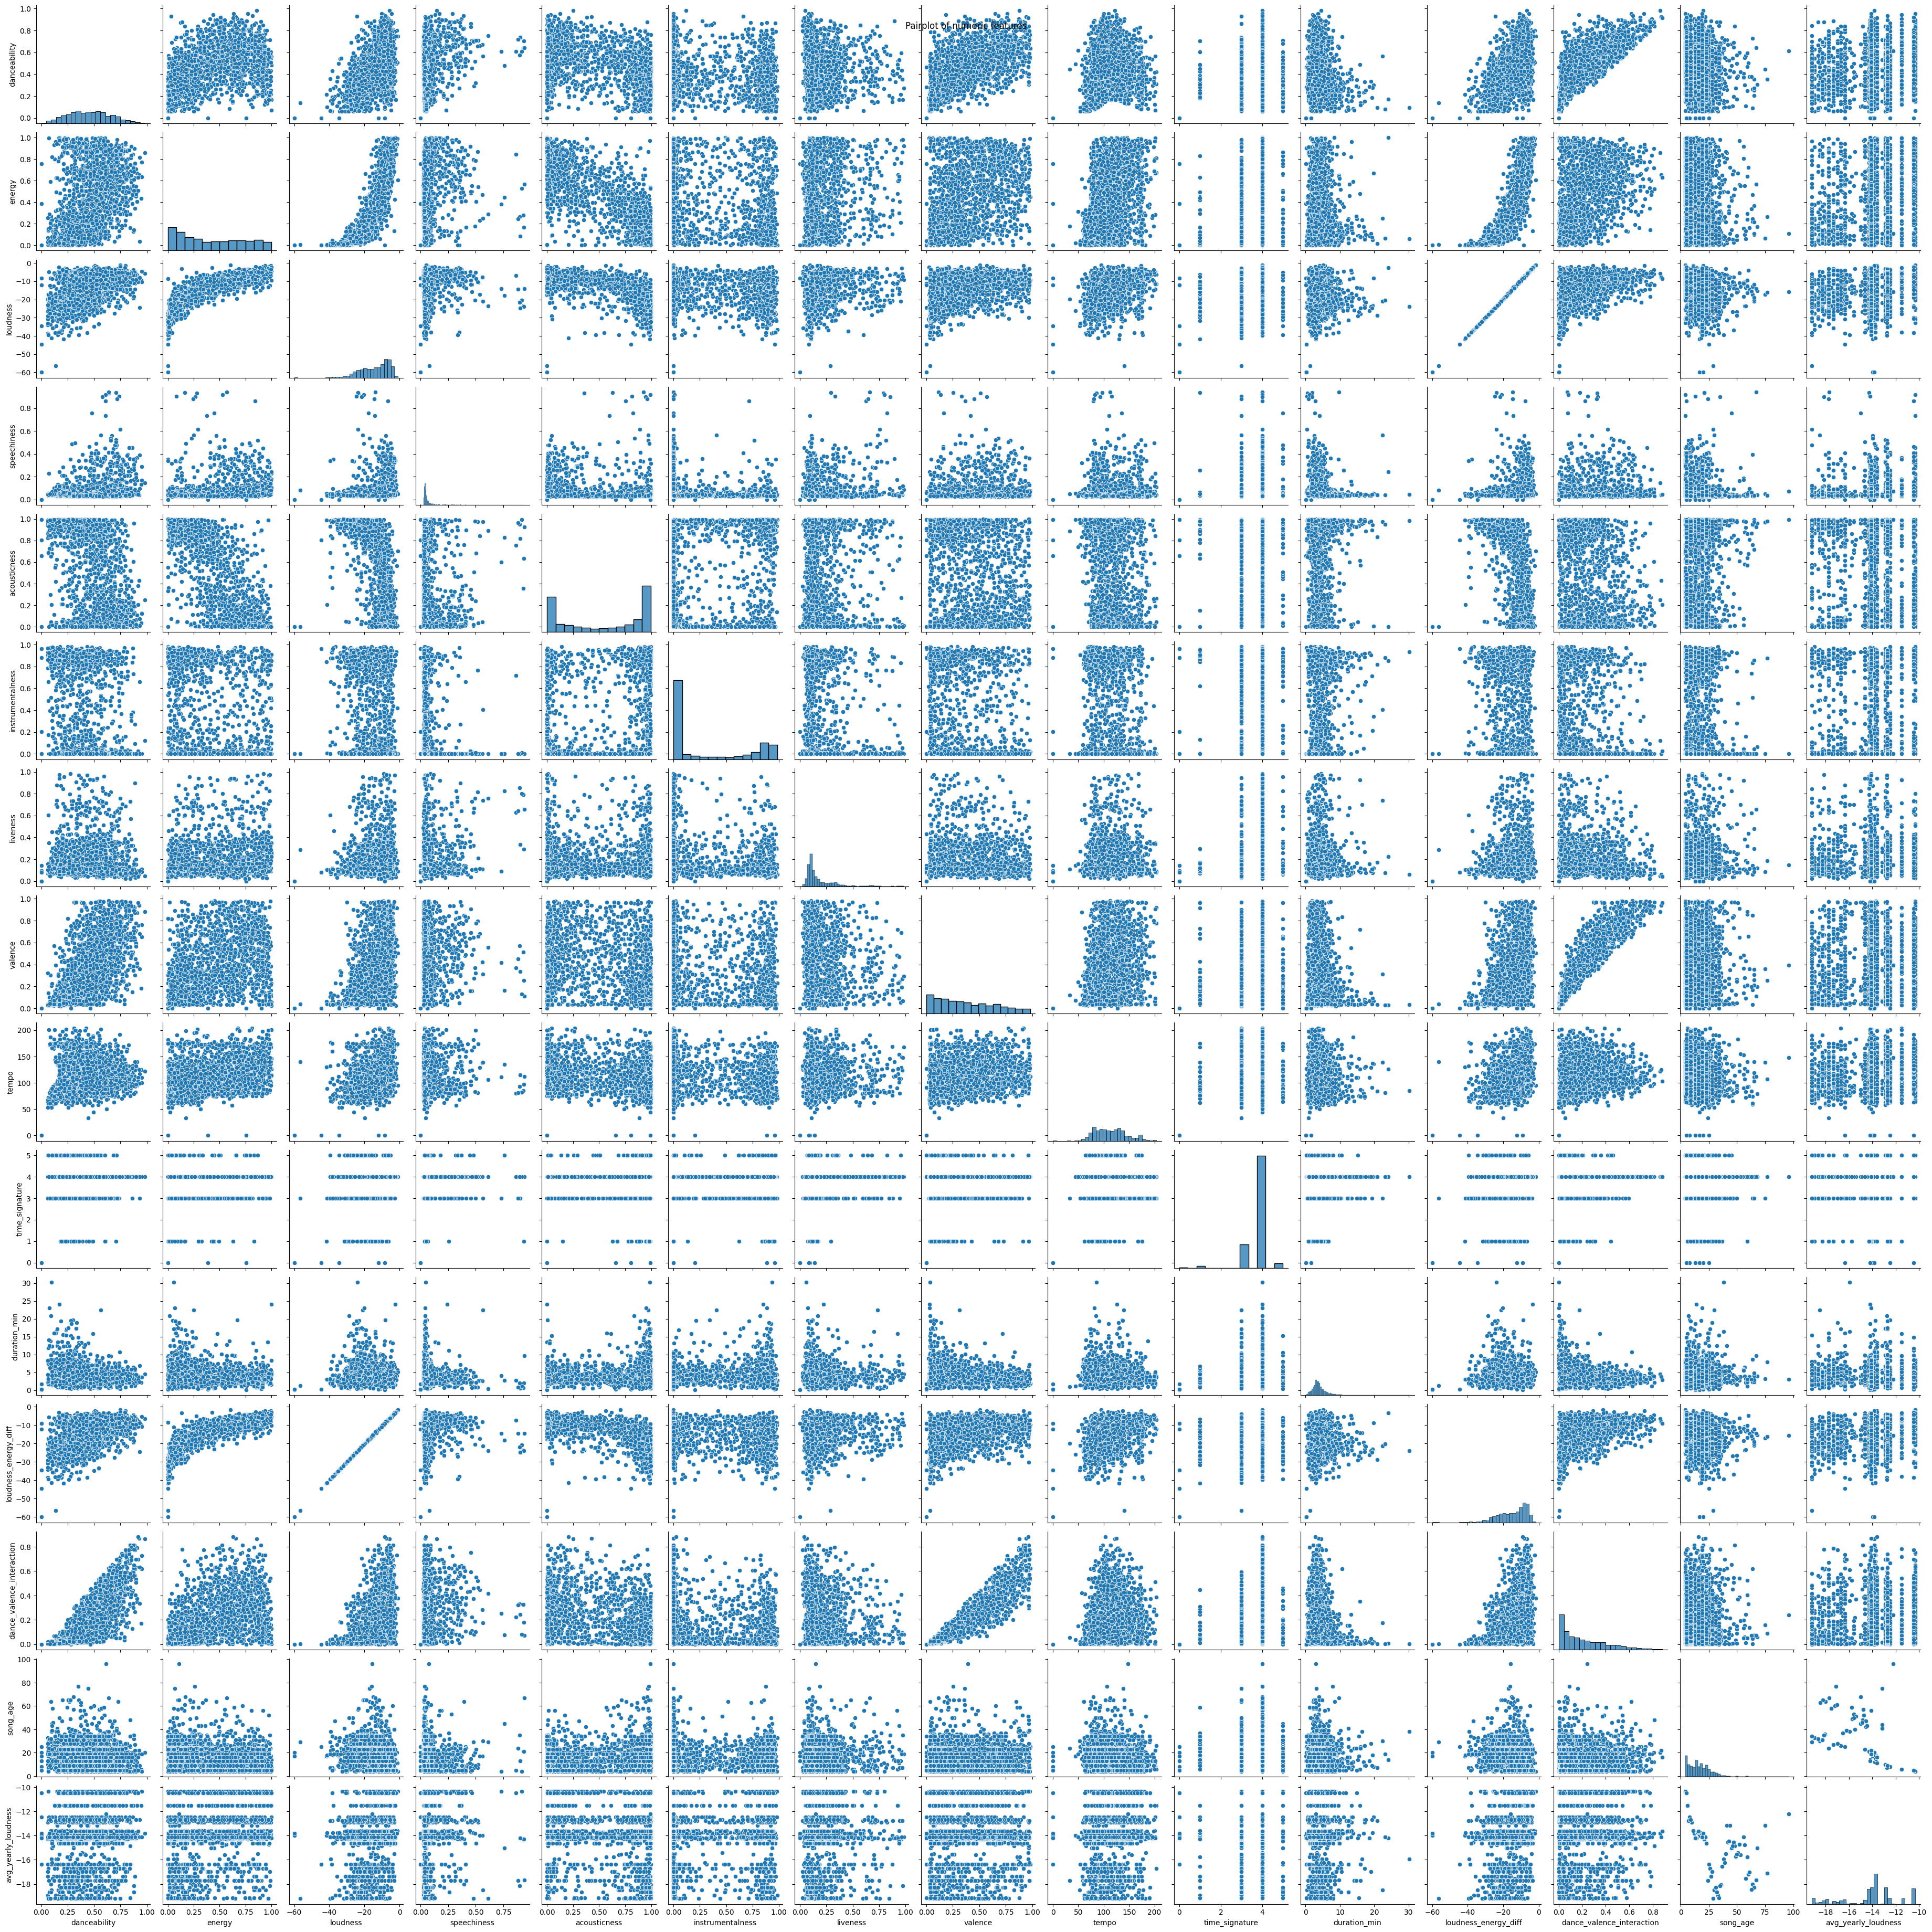

In [216]:
sns.pairplot(numeric_data.sample(.001).toPandas())
plt.suptitle("Pairplot of numeric features")
plt.savefig("../data/pairplot_all.png")
plt.show()

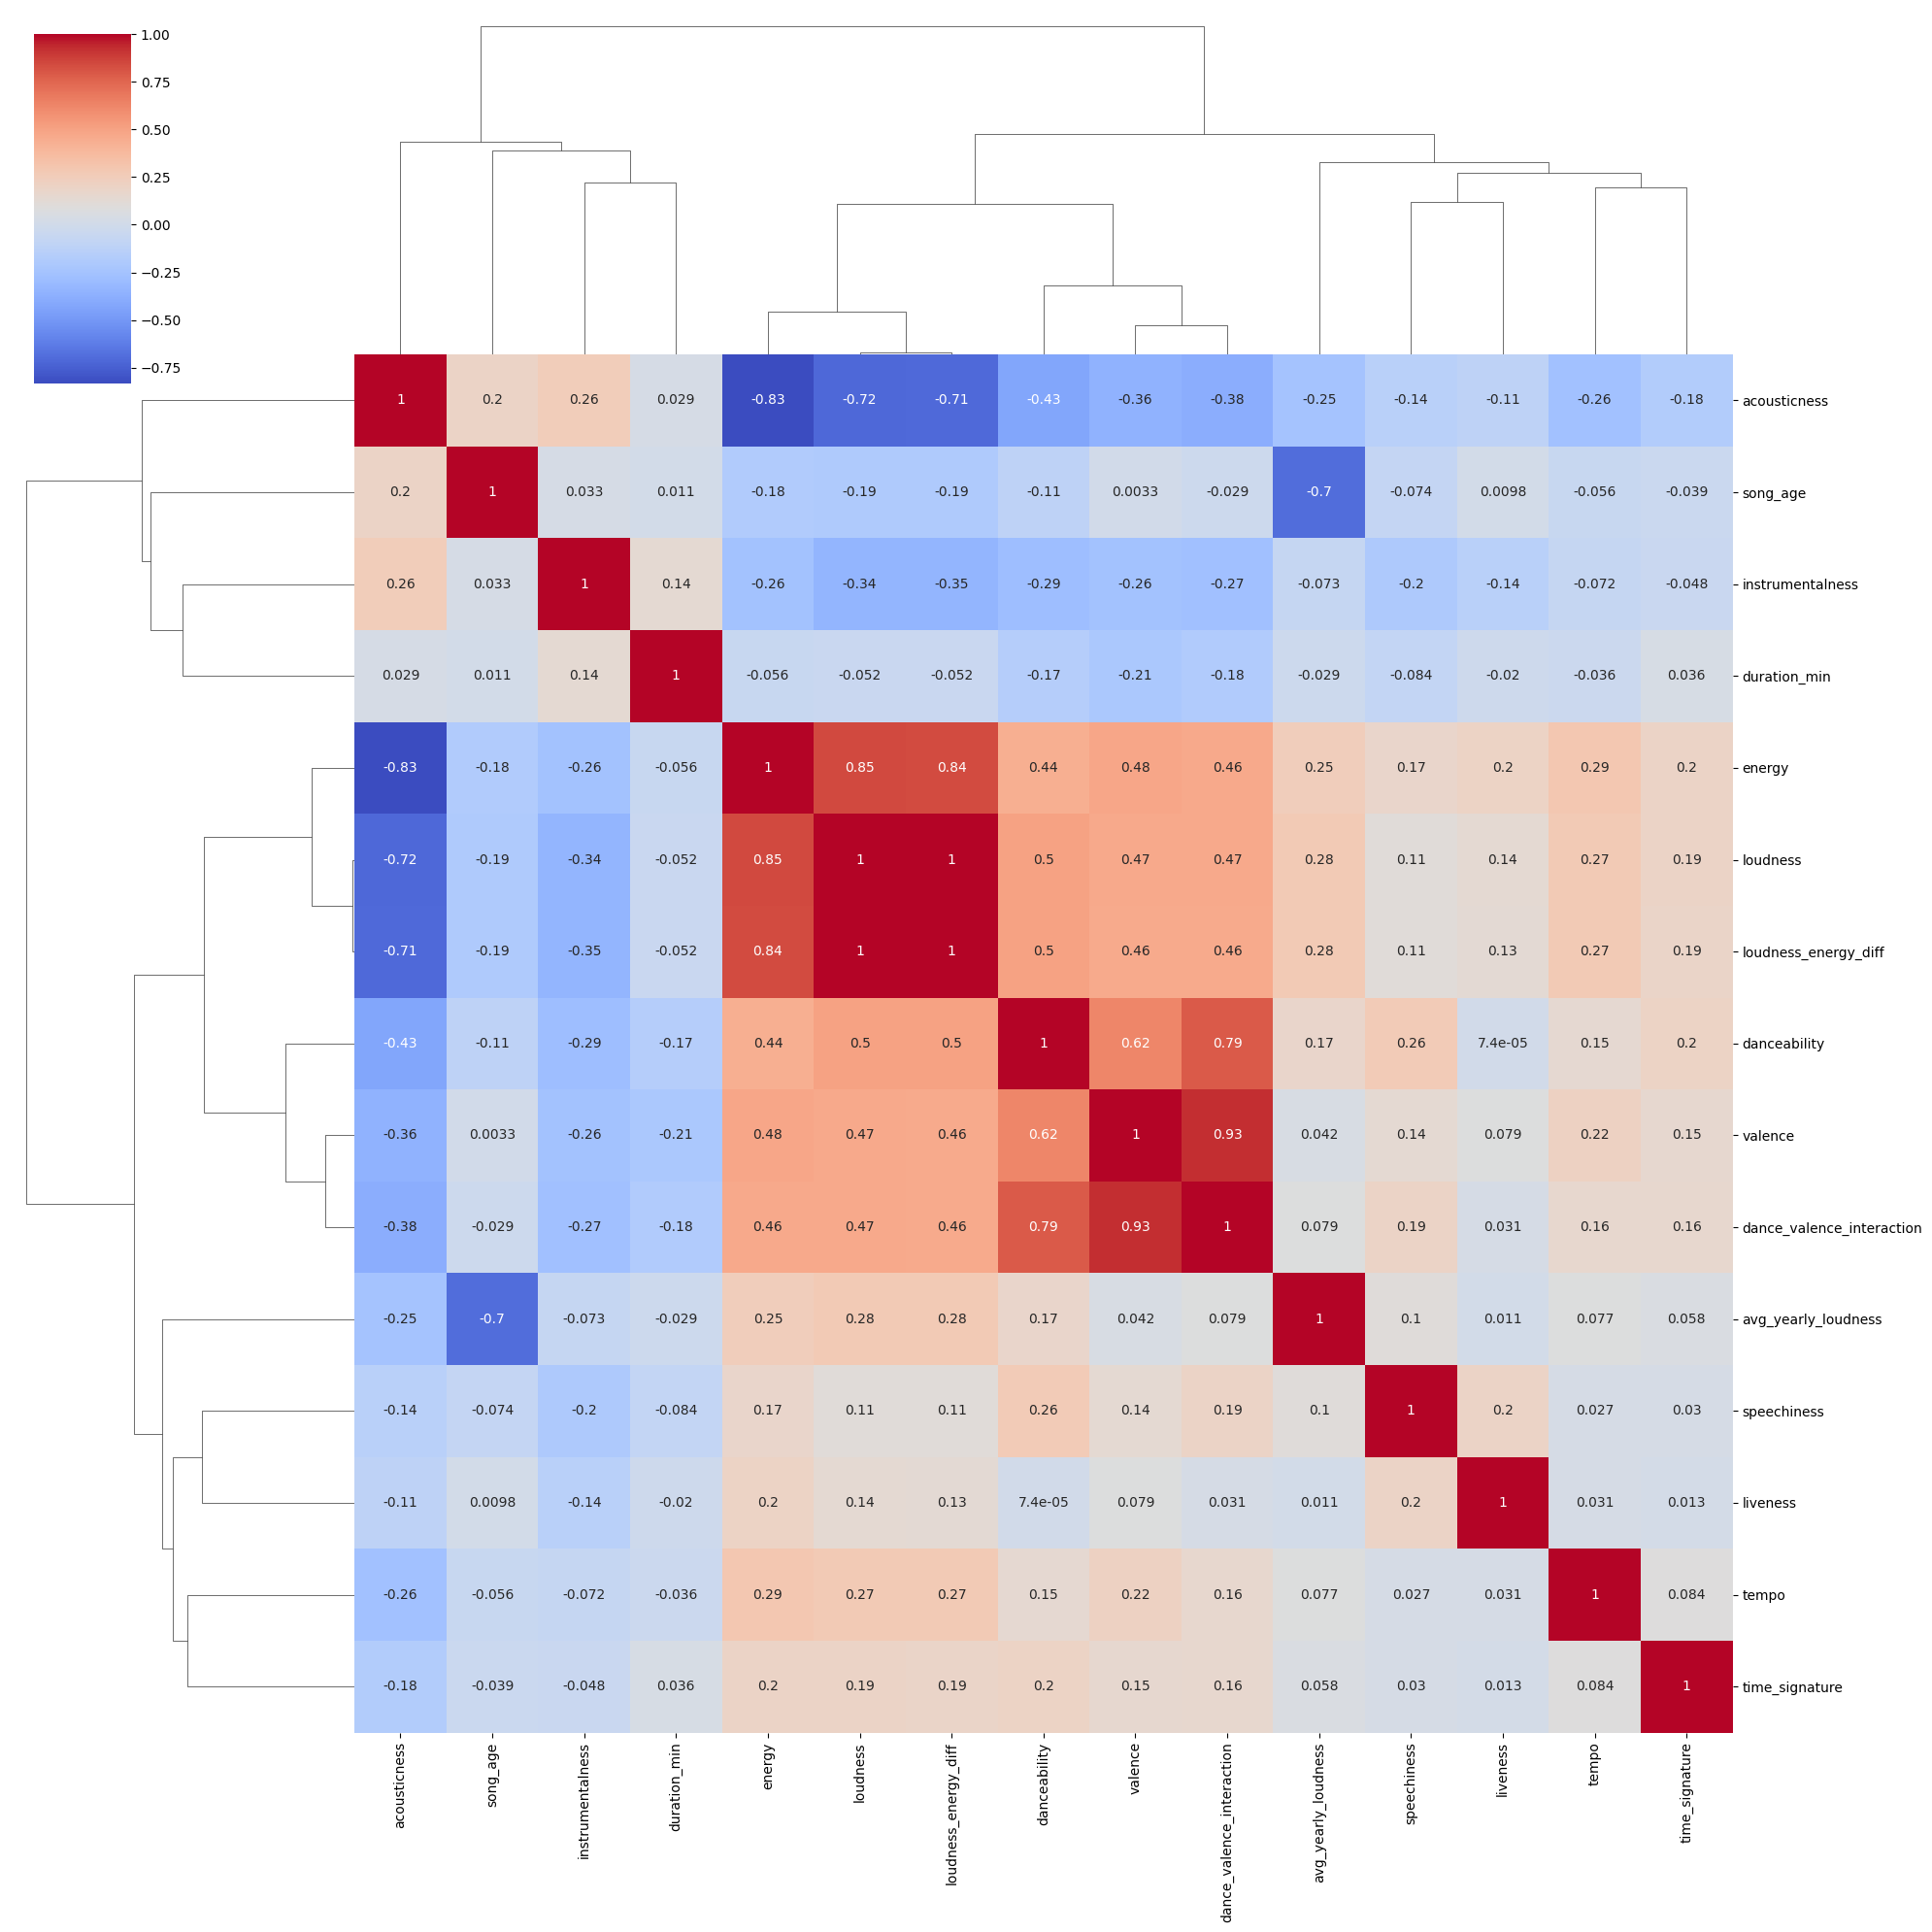

In [217]:
sns.clustermap(correlation_matrix, figsize=(20, 20), cmap="coolwarm", annot=True)
plt.show()

In [ ]:
song_lengths = df.select("duration_min").collect()
song_lengths = [row["duration_min"] for row in song_lengths]

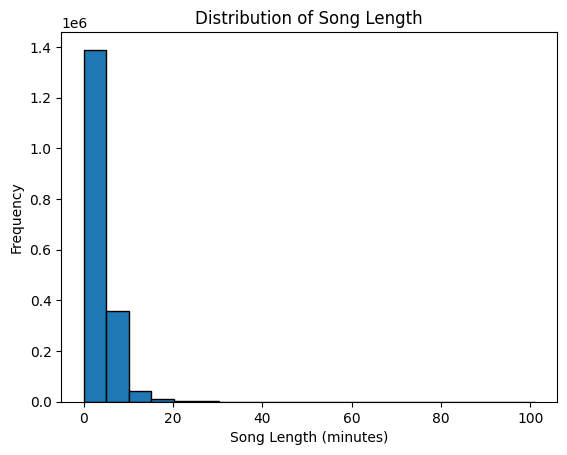

In [ ]:
plt.hist(song_lengths, bins=20, edgecolor="black")  
plt.xlabel("Song Length (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Song Length")
plt.show()

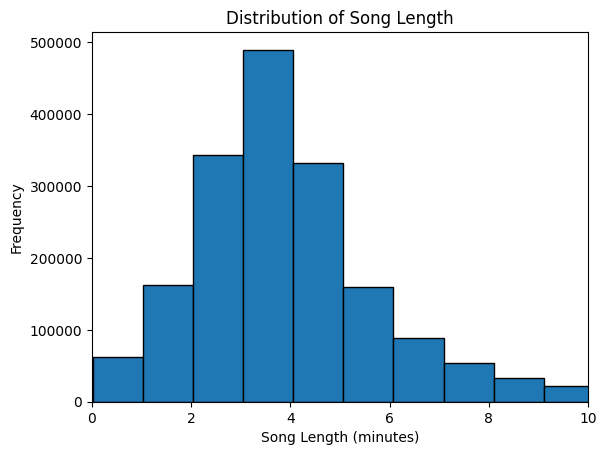

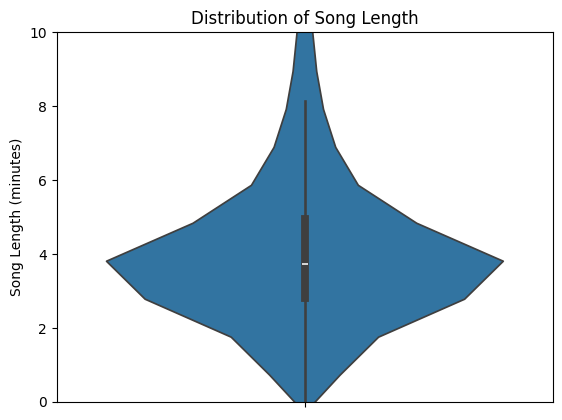

In [ ]:
plt.hist(song_lengths, bins=100, edgecolor="black")
plt.xlabel("Song Length (minutes)")
plt.ylabel("Frequency")
plt.xlim(0, 10)
plt.title("Distribution of Song Length")
plt.show()

sns.violinplot(y=song_lengths)
plt.ylabel("Song Length (minutes)")
plt.ylim(0, 10)
plt.title("Distribution of Song Length")
plt.show()

bluh bluh bluh

In [231]:
res_energy_loudness = df.select(corr("energy", "loudness").alias("correlation"))
print(f"Correlation between energy and loudness: {res_energy_loudness.collect()[0].correlation}")
res_energy_danceability = df.select(corr("energy", "danceability").alias("correlation"))
print(f"Correlation between energy and danceability: {res_energy_danceability.collect()[0].correlation}")

Correlation between energy and loudness: 0.8491554038418946
Correlation between energy and danceability: 0.43624853917374645


In [ ]:
res_danceability_valence = df.select(corr("danceability", "valence").alias("correlation"))
print(f"Correlation between danceability and valence: {res_danceability_valence.collect()[0].correlation}")
res_energy_valence = df.select(corr("energy", "valence").alias("correlation"))
print(f"Correlation between energy and valence: {res_energy_valence.collect()[0].correlation}")

In [ ]:
df = df.withColumn("mood", when((df["energy"] > 0.5) & (df["danceability"] > 0.5), "High Energy Danceable")
                      .otherwise(when((df["energy"] <= 0.5) & (df["danceability"] > 0.5), "Low Energy Danceable")
                      .otherwise(when((df["energy"] > 0.5) & (df["danceability"] <= 0.5), "High Energy Not Danceable")
                      .otherwise("Low Energy Not Danceable"))))

df.groupBy("mood").count().show()

In [ ]:
df.filter(df.valence > 0.5).agg({"danceability": "mean", "energy": "mean"}).show()
df.filter(df.valence <= 0.5).agg({"danceability": "mean", "energy": "mean"}).show()

In [ ]:
vecAssembler = VectorAssembler(inputCols=["energy", "loudness", "danceability"], outputCol="features")
df_kmeans = vecAssembler.transform(df)

kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df_kmeans.select("features"))
transformed = model.transform(df_kmeans) # this cell is not tested

In [220]:
columns = [
    "energy",
    "loudness",
    "acousticness",
    "instrumentalness",
    "valence",
    "speechiness",
    "tempo",
    "time_signature",
    "duration_min",
]

assembler = VectorAssembler(inputCols=columns, outputCol="features")
vectorized_data = assembler.transform(df)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(vectorized_data)

result = model.transform(vectorized_data).select("pcaFeatures")

result.show(truncate=False)

print(model.explainedVariance) # nice result

+----------------------------------------+
|pcaFeatures                             |
+----------------------------------------+
|[-108.82618603044651,19.514352835709786]|
|[-91.62617684130866,21.243865332480794] |
|[-96.43948156641552,22.62183089806264]  |
|[-88.76203352493644,19.672558363471897] |
|[-178.363844522285,27.23599036017019]   |
|[-88.81865353415263,19.22101215911055]  |
|[-118.57790724456392,23.392322395194928]|
|[-118.7916634949762,21.7628753715215]   |
|[-110.94343555842855,31.387485863081213]|
|[-144.30111238589612,28.328690883054893]|
|[-177.8004589283374,28.637001377943974] |
|[-182.73084593450278,29.291075131299714]|
|[-95.98642589274411,21.452412810699556] |
|[-104.30370262290329,20.096836260623746]|
|[-111.05857052983735,23.604925600581808]|
|[-94.219926974449,19.30055843425882]    |
|[-146.25422133720284,19.46320615868668] |
|[-90.38051640832965,18.244815258106065] |
|[-101.83473047422525,17.45001409875687] |
|[-131.99370352174031,21.71392264643221] |
+----------

In [223]:
sparse_to_dense = udf(lambda v: DenseVector(v.toArray()), VectorUDT())
result = result.withColumn("pcaFeatures", sparse_to_dense("pcaFeatures"))

In [224]:
vector_to_array = udf(lambda vector: vector.toArray().tolist(), ArrayType(FloatType()))
result = result.withColumn("pcaFeatures", vector_to_array("pcaFeatures"))

In [ ]:
result = result.withColumn("PC1", result["pcaFeatures"].getItem(0))
result = result.withColumn("PC2", result["pcaFeatures"].getItem(1))

PCA analysis which i'm tired to do and also pretty sure it's not needed 

QQQQQQQQQQQQQQQQQQ


lazy: PySpark DataFrames are lazily evaluated. They are implemented on top of RDDs. When Spark transforms data, it does not immediately compute the transformation but plans how to compute later. When actions such as collect() are explicitly called, the computation starts.

paraquet:  it smaller and more compact and bluh bluh   
https://www.databricks.com/glossary/what-is-parquet  
https://www.linkedin.com/pulse/perfect-file-format-unveiled-parquet-vs-csv-shailendra-prajapati/


checkpoint: save shit in middle to recover easier so i have to be aware of my life more and can't waste it more cause "im running the code bro so i get to relax"  
https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.checkpoint.html


stream:   
df.write.partitionBy("date").parquet("path/to/your/ass")


panda vs pyspark:
https://sparkbyexamples.com/pyspark/pandas-vs-pyspark-dataframe-with-examples/  
https://stackoverflow.com/questions/70177467/databricks-pyspark-vs-pandas